In [37]:
# This transfer learning script is adapted from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html by Zhicheng Pan
# credit goes to the original author Sasank Chilamkurthy

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' # adding this line to prevent kernel from dying when using plt.imshow

In [39]:
torch.cuda.is_available() # checking if GPU is available

True

In [40]:
torch.cuda.device_count() # GPU count

1

In [41]:
torch.cuda.get_device_name(0) # GPU name

'NVIDIA GeForce RTX 2060 SUPER'

In [42]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'training_qgram': v2.Compose([
        v2.ToImage(),  # Convert to tensor, only needed if you had a PIL image
        v2.ToDtype(torch.uint8, scale=True),  # optional, most input are already uint8 at this point
        #v2.RGB(),
        v2.Resize((224,224)),
        v2.RandomAffine(degrees=0,translate=(0.5,0)),
        v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # network specific normalization factors (ResNet18)
    ]),
    'testing_qgram': v2.Compose([
        v2.ToImage(),  # Convert to tensor, only needed if you had a PIL image
        v2.ToDtype(torch.uint8, scale=True),  # optional, most input are already uint8 at this point
        #v2.RGB(),
        v2.Resize((224,224)),
        v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # network specific normalization factors (ResNet18)
    ]),
}

data_dir = 'C:\\Users\\gfd9111\\AUT University\\EL Mehdi Zahraoui - SN-GW work\\New Simulation QGrams' # change this to your data directory
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['training_qgram', 'testing_qgram']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128,
                                             shuffle=True, num_workers=4)
              for x in ['training_qgram', 'testing_qgram']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['training_qgram', 'testing_qgram']}
class_names = image_datasets['training_qgram'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # whether to train with GPU

Visualize a few images
======================

Let\'s visualize a few training images so as to understand the data
augmentations.


In [43]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


In [44]:
# Get a batch of training data
#inputs, classes = next(iter(dataloaders['training_qgram']))

# Make a grid from batch
#out = torchvision.utils.make_grid(inputs[1:5,:,:,:])

# display the data
#imshow(out, title=[class_names[x] for x in classes[1:5]])

In [45]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10): 
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
    
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['training_qgram', 'testing_qgram']:
                if phase == 'training_qgram':
                    print("Training ...") # debugging prints, comment them out if not needed
                    model.train()  # Set model to training mode
                else:
                    print("Validation ...") # debugging prints, comment them out if not needed
                    model.eval()   # Set model to evaluate mode

                #print("running_loss ...") # debugging prints, comment them out if not needed
                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    #print("Iteration ...") # debugging prints, comment them out if not needed
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'training_qgram'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'training_qgram':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    # print("torch.sum ...") # debugging prints, comment them out if not needed
                    print(f'{phase} Loss: {loss.item() * inputs.size(0):.4f} Acc: {torch.sum(preds == labels.data):.4f}')
                    
                if phase == 'training_qgram':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'testing_qgram' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [46]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['testing_qgram']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the ConvNet
======================

Load a pretrained model and reset final fully connected layer.


In [47]:
model_ft = models.resnet18(weights='IMAGENET1K_V1') # loading the pretrained ResNet

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2) # setting output number of classes to 2

model_ft = model_ft.to(device) # GPU or CPU

criterion = nn.CrossEntropyLoss() # loss function

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-6, weight_decay=0.05)

# Constant learning rate
lambdaLR_scheduler = lr_scheduler.LambdaLR(optimizer_ft, lr_lambda=lambda epoch: 1)

In [48]:
model_ft = train_model(model_ft, criterion, optimizer_ft, lambdaLR_scheduler, num_epochs=1) # change this to 10 epochs

Epoch 0/0
----------
Training ...
running_loss ...
Iteration ...
torch.sum ...
Iteration ...
torch.sum ...
Iteration ...
torch.sum ...
Iteration ...
torch.sum ...
Iteration ...
torch.sum ...
Iteration ...
torch.sum ...
Iteration ...
torch.sum ...
Iteration ...
torch.sum ...
Iteration ...
torch.sum ...
Iteration ...
torch.sum ...
Iteration ...
torch.sum ...
Iteration ...
torch.sum ...
Iteration ...
torch.sum ...
Iteration ...
torch.sum ...
Iteration ...
torch.sum ...
Iteration ...
torch.sum ...
Iteration ...
torch.sum ...
Iteration ...
torch.sum ...
Iteration ...
torch.sum ...
Iteration ...
torch.sum ...
Iteration ...
torch.sum ...
Iteration ...
torch.sum ...
Iteration ...
torch.sum ...
Iteration ...
torch.sum ...
Iteration ...
torch.sum ...
Iteration ...
torch.sum ...
Iteration ...
torch.sum ...
Iteration ...
torch.sum ...
Iteration ...
torch.sum ...
Iteration ...
torch.sum ...
Iteration ...
torch.sum ...
Iteration ...
torch.sum ...
Iteration ...
torch.sum ...
Iteration ...
torch.sum .

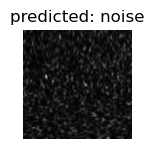

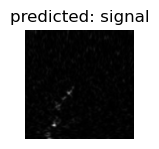

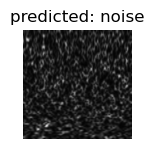

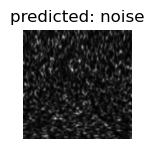

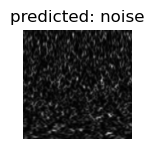

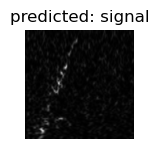

In [49]:
visualize_model(model_ft) # make a few predictions